## Домашнее задание

#### 1. К алгоритму kNN, представленному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

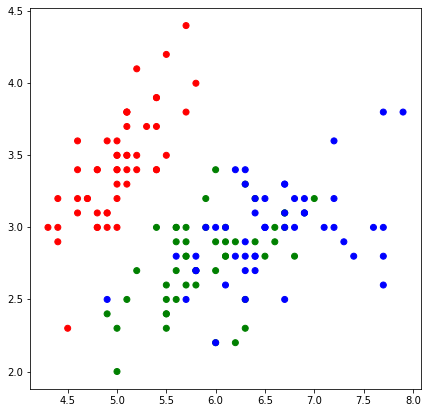

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [6]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
            
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
#         print(classes)   
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])

    return answers

Реализуем алгоритм поиска k ближайших соседей с весами

Добавим соседям веса, вычисленные по формуле:
$$w(d) = q^{d},   q \in (0,1), $$

где d - рсстояние

In [7]:
def knn_weight(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
            
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d, i in zip(sorted(test_distances)[0:k], range(1, k+1)):
            classes[d[1]] += 0.8**d[0]
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
#         print(classes)

    return answers

Напишем функцию для вычисления точности

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [9]:
accuracies = []
for k in range(2, 21):
    y_pred = knn(X_train, y_train, X_test, k)
    y_pred_weight = knn_weight(X_train, y_train, X_test, k)
    accuracies.append([k, float(f'{accuracy(y_pred, y_test):.3f}'), float(f'{accuracy(y_pred_weight, y_test):.3f}')])

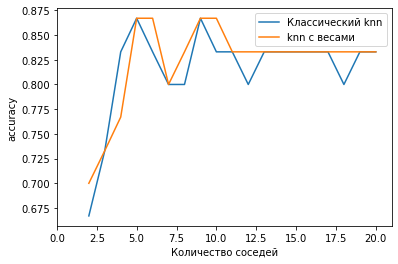

In [10]:
# Сравним accuracy алгоритмов
plt.xlabel('Количество соседей')
plt.ylabel('accuracy')
plt.xlim(0, list(zip(*accuracies))[0][-1] + 1)
plt.plot(list(zip(*accuracies))[0], list(zip(*accuracies))[1], label='Классический knn')
plt.plot(list(zip(*accuracies))[0], list(zip(*accuracies))[2], label='knn с весами')
plt.legend(loc='best')
plt.show()

##### Вывод: Из графика видно, что алгоритм с весами работает лучше. Только при количестве соседей 3 классический knn работает лучше, во всех остальных случаях knn с весами работает или одинаково или лучше

#### 2. (*) Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из этого урока (создать датасет, как в методичке).

Сосздадим датасет

In [11]:
from sklearn.datasets import make_blobs
import random
X, y = make_blobs(n_samples=100, random_state=1)

In [12]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        old_classes = classes.copy()
        classes = {i: [] for i in range(k)}
#         print(f'На {_} итерации классы = {old_classes}')
        for x in data:
            
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
#             print(f'class = {classes}')
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
#         print(f'После цикла алгоритма класс = {classes}')
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
#         print(wss(centroids, classes))    
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break

    return old_centroids, classes

Напишем функцию для рассчета среднего квадратичного внутриклассового расстояния по формуле
    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$
 где $|k|$ - количество элементов в кластере под номером $k$.

In [13]:
def average_square_class_distance(centroids, clusters):
    a_sq_cla_dist = 0
    for i in clusters:
        distance = np.sum([e_metrics(x, centroids[i])**2 for x in clusters[i]]) / len(clusters[i])
        a_sq_cla_dist += distance   
    return a_sq_cla_dist    

Рассчитаем средние квадратичные внутриклассовые расстояния для различного количества центроидов

In [14]:
a_sq_cla_dists = []
for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations=10, min_distance=1e-4)
    a_sq_cla_dists.append(average_square_class_distance(centroids, clusters))

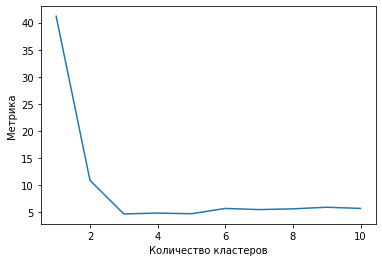

In [15]:
# построим график зависимости среднего квадратичного внутриклассового расстояния от количества кластеров k
plt.xlabel('Количество кластеров')
plt.ylabel('Метрика')
plt.plot([i for i in range(1, 11)], a_sq_cla_dists);

Видим, что наименьшая метрика достигается при количесве центроидов 3

Сделам проверку правильности расчетов. В библиотеке sklearn есть модель KMeans. У нее есть метод inertia_, который показывает значение целевой функции - суммы квадратов внутриклассовых расстояний, рассчитанной по формуле:
    $$\sum_{k=1}^{K}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k})$$
    
Рассчитаем ее с помощью методов библиотеки sklearn для разного количества центроидов

In [16]:
from sklearn.cluster import KMeans
inercias = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inercias.append(model.inertia_)

In [17]:
inercias

[4118.153777704471,
 661.5698490972003,
 156.28289251170003,
 130.96121900774804,
 112.05653036061504,
 96.26315742705445,
 81.49760027212565,
 69.70669902233496,
 62.82959029286148,
 54.408866472636056]

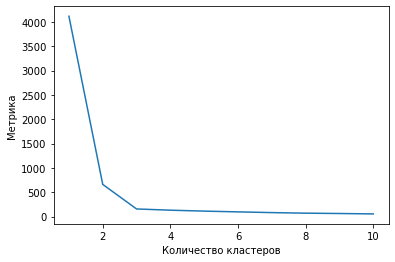

In [18]:
# построим график зависимости среднего квадратичного внутриклассового расстояния от количества кластеров k
plt.xlabel('Количество кластеров')
plt.ylabel('Метрика')
plt.plot([i for i in range(1, 11)], inercias);

Изменим нашу фугкцию и посмотрим какие рассчеты покажет она

In [19]:
def average_square_class_distance(centroids, clusters):
    a_sq_cla_dist = 0
    for i in clusters:
        distance = np.sum([e_metrics(x, centroids[i])**2 for x in clusters[i]])
        a_sq_cla_dist += distance   
    return a_sq_cla_dist    

In [20]:
a_sq_cla_dists = []
for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations=10, min_distance=1e-4)
    a_sq_cla_dists.append(average_square_class_distance(centroids, clusters))

In [21]:
a_sq_cla_dists

[4118.153777704471,
 661.5698490972001,
 156.28289251170003,
 139.3741146136838,
 126.57537841891627,
 115.8130108490437,
 101.33706078363487,
 98.00829163101346,
 72.88769594879396,
 58.46251834933362]

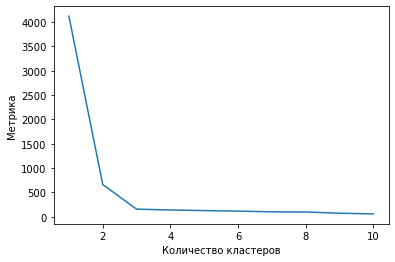

In [22]:
# построим график зависимости среднего квадратичного внутриклассового расстояния от количества кластеров k
plt.xlabel('Количество кластеров')
plt.ylabel('Метрика')
plt.plot([i for i in range(1, 11)], a_sq_cla_dists);

Видим, что цифры и графики очень похожи, значит наши рассчеты были верные